# Digital Image Processing CS663
---
## Final Project
### Dhruv Meena, 22b1279
---

### JPEG Image Compression Engine

In this project I have implemented a compression engine using jpeg algorithm. I have used OpenCV to calculate the DCT coefficients and huffman library for the encoding.




## Libraries + Error Functions

In [118]:
!pip install huffman
!pip install bitarray
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import heapq
from collections import Counter
from PIL import Image
import huffman
import os
import ast
import bitarray
import pickle
import struct


In [120]:
# Mean Squared Error function
def rmse(compressed, original):
  assert len(compressed) == len(original), "The compressed image and the original image are not of the same size!"
  return np.sqrt(np.mean((compressed-original)**2))

def calculate_bpp(file_path, rows, cols):
    compressed_size = os.stat(file_path).st_size * 8
    num_pixels = rows * cols
    bpp = compressed_size / num_pixels
    return bpp

##  Encoding

In [121]:
# Padding
def pad(img):
    '''
    Function to pad the image by increasing the width or height to the nearest multiple of 8
    '''
    rows, cols = img.shape[:2]
    pad_bottom = 8 - (rows % 8) if rows % 8 != 0 else 0
    pad_right = 8 - (cols % 8) if cols % 8 != 0 else 0
    padded_img = cv.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, cv.BORDER_CONSTANT, value=128)
    return padded_img, pad_bottom, pad_right

# DCT
def DCT(block):
  '''
  Function to calculate the DCT of a block
  '''
  if block.shape != (8, 8):
    raise ValueError("Input block must be an 8x8 matrix.")
  block = block.astype(np.float32)
  block = block - 128
  block = cv.dct(block)
  return block

In [122]:
# Quantization Matrix
M = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quantization
def quantize(block, Q):
  '''
  Function to quantize a block using the quantization matrix
  '''
  if Q <= 0 or Q > 100:
        raise ValueError("Quality factor Q must be in the range 1–100.")
  M_ = (50/Q) * M
  block = np.round(block/M_)
  return block.astype('int')

In [123]:
# Zigzag ordering
zigzag_indices = np.array([
      (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
      (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
      (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
      (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
      (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
      (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
      (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
      (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
  ])

def zigzag(block):
  '''
  Function to zigzag order a block
  '''
  zig_block = [block[x, y] for x, y in zigzag_indices]
  return zig_block

In [124]:
# Run Length Encoding
def rle(zig_block):
    '''
    Function to run length encode a block
    '''
    rle = []
    zero_count = 0
    for value in zig_block:
        if value == 0:
            zero_count += 1
            if zero_count > 15:
              rle.append((15,0))
              zero_count = 0
        else:
            rle.append((zero_count, value))
            zero_count = 0
    rle.append((0, 0))
    return rle

In [125]:
def huffman_encode_dc(DC_coeffs):
    '''
    Function to huffman encode the DC coefficients by taking the first DC coefficient as it is
    and then taking the differences of the rest of the DC coefficients. Huffman Library used for the codebook.
    '''
    dc_differences = [DC_coeffs[0]] + [DC_coeffs[i] - DC_coeffs[i - 1] for i in range(1, len(DC_coeffs))]
    freq = Counter(dc_differences)
    huffman_dict = huffman.codebook(freq.items())
    encoded_data = "".join(huffman_dict[diff] for diff in dc_differences)
    return encoded_data, huffman_dict

def huffman_encode_ac(blocks_rle):
    '''
    Function to huffman encode the AC coefficients.
    '''
    RLE = [item for block in blocks_rle for item in block]
    frequency = Counter(RLE)
    huffman_dict = huffman.codebook(frequency.items())
    encoded_data = "".join(huffman_dict[tuple] for tuple in RLE)
    return encoded_data, huffman_dict

In [126]:
# JPEG Compression
def jpeg_compression(img_path,Q):
    '''
    Function to compress an image using JPEG algorithm, the pipeline.
    '''

    load_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE) # Load Image
    img = np.array(load_image) # Convert to np.array() for better handling
    img, pad1, pad2 = pad(img) # Pad the image, also unpack the padding lengths

    rows, cols = img.shape[:2] # Get dimensions of the padded image
    #print(f"Padded image size: {rows}x{cols}, Padding: {pad1}, {pad2}")

    blocks = [] # Initialize the blocks list

    # get separate blocks
    for i in range(0, rows, 8):
      for j in range(0, cols, 8):
        block = img[i:i+8, j:j+8] # get individual blocks 8x8
        blocks.append(block) # append each 8x8 as a list to blocks

    # get dct coefficients
    blocks_dct = [DCT(block) for block in blocks]

    # quantize
    blocks_quantize = [quantize(block,Q) for block in blocks_dct]

    # zigzag ordering
    blocks_zigzag = [zigzag(block) for block in blocks_quantize]

    # get dc and ac coefficients
    DC_coefficients = [DC[0] for DC in blocks_zigzag]
    AC_coefficients = [AC[1:] for AC in blocks_zigzag]

    # get huffman dicts
    encoded_data_DC, huffman_dict_DC = huffman_encode_dc(DC_coefficients)
    RLE_encoded_blocks = [rle(block) for block in AC_coefficients]
    encoded_data_AC, huffman_dict_AC = huffman_encode_ac(RLE_encoded_blocks)

    return encoded_data_DC, encoded_data_AC, huffman_dict_DC, huffman_dict_AC, Q, rows, cols, pad1, pad2

## Writing and Reading Files

In [164]:
'''
How this works:
 - We can not directly store the huffman dictionaries without using up a lot of space,
   therefore, we serialize it. We store the keys and their symbols seperately. All tuple
   elements are converted into python ints and packed as a byte. We also store the tuple lengths.
 - Next, we write the metadata as binary in a certain order: Rows, Cols, Q, bitDC, bitAC, huffDC, huffAC.
 - In deserialization, we initialize a dict and an offset. We increase offset by the size of the key or symbol
   we encounter and store it as we traverse the compressed data. We append the keys in dictionary and return it
 - For reading, we also do it in order that we wrote it in. We have the lengths of the bytes that we are reading.
   We call deserialization for the dictionaries. We also stored their sizes so we know exactly how long they are
   when we are deserializing.
'''
def serialize_huffman_dict(huff_dict):
    """Serialize a Huffman dictionary into a compact binary representation."""
    serialized = bytearray()
    for key, value in huff_dict.items():
        # Normalize key type
        if isinstance(key, (np.integer, int)):  # Handle numpy integers and Python integers
            key = int(key)  # Convert numpy integer to Python integer
            key_type = 0  # Type indicator for integer
            key_data = struct.pack('i', key)  # Pack as 4-byte signed int (note: 'i' for signed)
        elif isinstance(key, tuple):  # Tuple keys (e.g., huffman_dict_AC)
            key_type = 1  # Type indicator for tuple
            key_data = struct.pack('B', len(key))  # Pack tuple length as 1 byte
            key_data += b''.join(struct.pack('i', int(k)) for k in key)  # Convert tuple elements to Python ints
        else:
            raise ValueError(f"Unsupported key type: {type(key)}")

        # Serialize the value (binary string)
        value_bits = int(value, 2).to_bytes((len(value) + 7) // 8, byteorder='big')  # Convert value to bytes
        value_len = len(value_bits)

        # Write serialized data
        serialized.extend(struct.pack('B', key_type))  # Write key type (1 byte)
        serialized.extend(struct.pack('H', len(key_data)))  # Write key data length (2 bytes)
        serialized.extend(key_data)  # Write key data
        serialized.extend(struct.pack('H', value_len))  # Write value length (2 bytes)
        serialized.extend(value_bits)  # Write value as bytes
    return serialized

def write_compressed_bitstream(filename, bitstreamDC, bitstreamAC, dict1, dict2, rows, cols, Q):
    ba_dc = bytearray()
    ba_ac = bytearray()
    ba_dc.extend(int(bitstreamDC, 2).to_bytes((len(bitstreamDC) + 7) // 8, byteorder='big'))
    ba_ac.extend(int(bitstreamAC, 2).to_bytes((len(bitstreamAC) + 7) // 8, byteorder='big'))

    # Serialize Huffman dictionaries
    serialized_dict1 = serialize_huffman_dict(dict1)
    serialized_dict2 = serialize_huffman_dict(dict2)

    bin_rows = struct.pack('H', rows)
    bin_cols = struct.pack('H', cols)
    bin_Q = struct.pack('B', Q)

    with open(filename, 'wb') as file:
        file.write(bin_rows)
        file.write(bin_cols)
        file.write(bin_Q)
        file.write(struct.pack('I', len(ba_dc)))  # Write DC bitstream length
        file.write(struct.pack('I', len(ba_ac)))  # Write AC bitstream length
        file.write(ba_dc)
        file.write(ba_ac)
        file.write(struct.pack('I', len(serialized_dict1)))  # Serialize the dictionary size first
        file.write(serialized_dict1)
        file.write(struct.pack('I', len(serialized_dict2)))  # Serialize the dictionary size first
        file.write(serialized_dict2)

    print(f"Compressed data written to {filename}")

def deserialize_huffman_dict(serialized):
    """Deserialize a compact binary Huffman dictionary."""
    huff_dict = {}
    offset = 0
    while offset < len(serialized):
        key_type = struct.unpack('B', serialized[offset:offset+1])[0]  # Read key type (1 byte)
        offset += 1
        key_len = struct.unpack('H', serialized[offset:offset+2])[0]  # Read key length (2 bytes)
        offset += 2

        if key_type == 0:  # Integer key
            key = struct.unpack('i', serialized[offset:offset+4])[0]  # Read 4 bytes for an integer (signed)
            offset += 4
        elif key_type == 1:  # Tuple key
            tuple_len = struct.unpack('B', serialized[offset:offset+1])[0]  # Read tuple length (1 byte)
            offset += 1
            key = tuple(struct.unpack(f'{tuple_len}i', serialized[offset:offset + tuple_len * 4]))  # Read tuple of integers
            offset += tuple_len * 4

        value_len = struct.unpack('H', serialized[offset:offset+2])[0]  # Read value length (2 bytes)
        offset += 2
        value_bits = serialized[offset:offset+((value_len + 7) // 8)]  # Read the value bits as bytes
        offset += (value_len + 7) // 8

        # Convert the bytes to binary string
        value_str = bin(int.from_bytes(value_bits, byteorder='big'))[2:].zfill(value_len)
        huff_dict[key] = value_str  # Store the value as a binary string

    return huff_dict

def read_compressed_bitstream(filename):
    with open(filename, 'rb') as file:
        rows = struct.unpack('H', file.read(2))[0]
        cols = struct.unpack('H', file.read(2))[0]
        Q = struct.unpack('B', file.read(1))[0]

        # Read DC and AC bitstream lengths
        dc_length = struct.unpack('I', file.read(4))[0]
        ac_length = struct.unpack('I', file.read(4))[0]

        # Read DC bitstream
        ba_dc = bytearray(file.read(dc_length))

        # Read AC bitstream
        ba_ac = bytearray(file.read(ac_length))

        # Read dictionary sizes
        dict1_size = struct.unpack('I', file.read(4))[0]
        dict1_serialized = file.read(dict1_size)
        dict1 = deserialize_huffman_dict(dict1_serialized)

        dict2_size = struct.unpack('I', file.read(4))[0]
        dict2_serialized = file.read(dict2_size)
        dict2 = deserialize_huffman_dict(dict2_serialized)

    return rows, cols, Q, ''.join(format(byte, '08b') for byte in ba_dc), ''.join(format(byte, '08b') for byte in ba_ac), dict1, dict2

## Decoding

In [128]:
# Inverse DCT
def idct(zig,Q):
  '''
  Function to find the inverse DCT of the blocks.
  '''

  if zig.shape != (8, 8):
    raise ValueError("Input zig must be an 8x8 matrix.")
  if Q <= 0 or Q > 100:
    raise ValueError("Quality factor Q must be in the range 1–100.")

  M_ = float(50/Q) * M

  zig = zig*M_
  zig = cv.idct(zig)
  zig = zig + 128
  return np.clip(zig, 0, 255).astype(np.uint8)

In [129]:
def huffman_decode(bitstream, huff_codes):
  '''
  Function to decode the huffman encoded data.
  '''
  reversed_dict = {symbol: key for key, symbol in huff_codes.items()}
  decoded_block = []

  temp = ""
  decoded_blocks = []

  for bit in bitstream:
        temp += bit
        if temp in reversed_dict:
            symbol = reversed_dict[temp]
            decoded_block.append(symbol)
            temp = ""

            if symbol == (0, 0):
                decoded_blocks.append(decoded_block)
                decoded_block = []
  if decoded_block:
    if decoded_block[-1] != (0, 0):
      decoded_block.append((0, 0))
    decoded_blocks.append(decoded_block)
  return decoded_blocks

In [130]:
def huffman_decode_dc(bitstream, huff_codes):
    '''
    Function to decode the huffman encoded DC data.
    '''
    reversed_dict = {symbol: key for key, symbol in huff_codes.items()}

    decoded_sequence = []
    temp = ""

    for bit in bitstream:
        temp += bit
        if temp in reversed_dict:
            decoded_sequence.append(int(reversed_dict[temp]))
            temp = ""

    for i in range(1,len(decoded_sequence)):
        decoded_sequence[i] += decoded_sequence[i-1]
    return decoded_sequence

In [131]:
def inverse_rle(decoded_AC, decodedDC):
    '''
    Function to decode the run length encoded data.
    '''
    decoded_blocks_ = []

    for block in decoded_AC:
        block_curr = []
        for runlength, value in block:
            if (runlength, value) == (0, 0):
                break
            block_curr.extend([0] * runlength)
            block_curr.append(value)

        while len(block_curr) < 63:
            block_curr.append(0)

        decoded_blocks_.append(block_curr)

    decoded_blocks = [[decodedDC[i]] + decoded_blocks_[i] for i in range(len(decodedDC))]
    return decoded_blocks

In [132]:
def zigzag_rev(decoded_blocks):
    '''
    Function to invert the zigzag ordered data.
    '''
    results = []
    for block in decoded_blocks:
        result = np.zeros((8, 8), dtype=np.float32)
        for idx, (row, col) in enumerate(zigzag_indices):
            result[row, col] = block[idx]
        results.append(result)
    return results

In [133]:
def reconstruct_image(blocks, padded_shape, original_shape, block_size=8):
    reconstructed_image = np.zeros(padded_shape, dtype=np.float32)
    i, j = 0, 0

    for block in blocks:
        reconstructed_image[i:i+block_size, j:j+block_size] = block
        j += block_size
        if j >= padded_shape[1]:
            j = 0
            i += block_size

    original_rows, original_cols = original_shape
    reconstructed_image_cropped = reconstructed_image[:original_rows, :original_cols]

    return reconstructed_image_cropped.astype(np.uint8)

In [161]:
def jpeg_decode(rows, cols, Q,bitstreamDC, bitstreamAC, dc_huffman_codes, ac_huffman_codes):
  '''
  JPEG Decoding function using read_compressed_bitstream() method
  '''
  decodedAC = huffman_decode(bitstreamAC, ac_huffman_codes)
  decodedDC = huffman_decode_dc(bitstreamDC, dc_huffman_codes)
  decoded_blocks = inverse_rle(decodedAC,decodedDC)
  zigzagged_blocks = zigzag_rev(decoded_blocks)
  restored_blocks = [idct(block_zig,Q) for block_zig in zigzagged_blocks]
  restored_image = reconstruct_image(restored_blocks, (rows, cols), (rows, cols))
  return restored_image

## Pipeline

In [162]:
def engine(image_path,Q, file_path):
  # COMPRESS AND ENCODE
  encoded_data_DC, encoded_data_AC, huffman_dict_DC, huffman_dict_AC, Q, rows, cols, pad1, pad2 = jpeg_compression(image_path,Q)

  # WRITE ENCODED FILE
  write_compressed_bitstream(file_path, encoded_data_DC, encoded_data_AC, huffman_dict_DC, huffman_dict_AC, rows, cols, Q)

  # READ ENCODED FILE
  rowsc, colsc, Qc, bitstreamDCc, bitstreamACc, dict1c, dict2c = read_compressed_bitstream(file_path)

  # DECODE AND RECONSTRUCT
  compressed_image = jpeg_decode(rows, cols, Q, encoded_data_DC, encoded_data_AC, huffman_dict_DC, huffman_dict_AC)

  return compressed_image

## Results

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


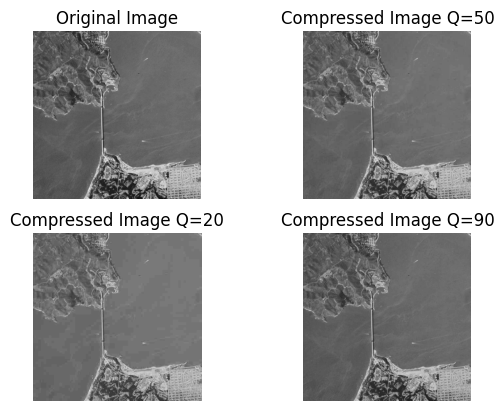

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


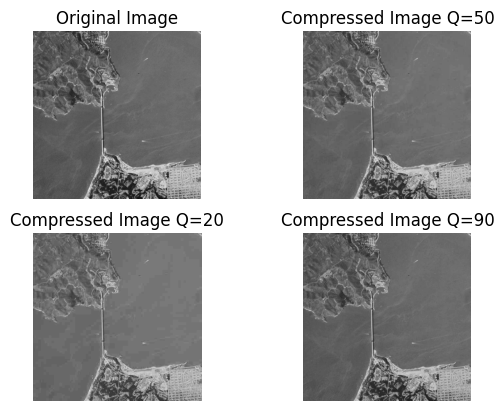

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


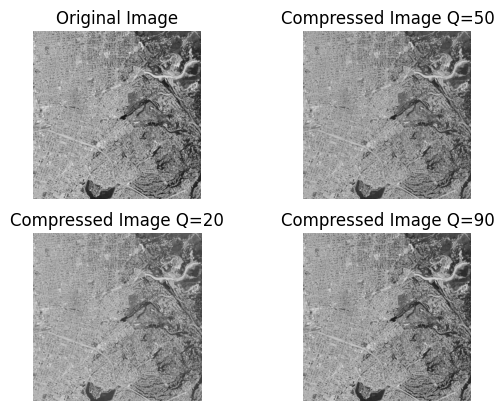

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


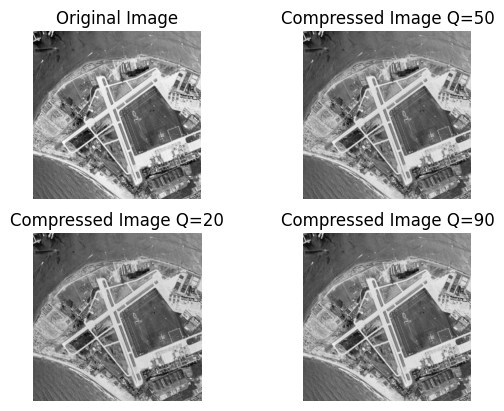

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


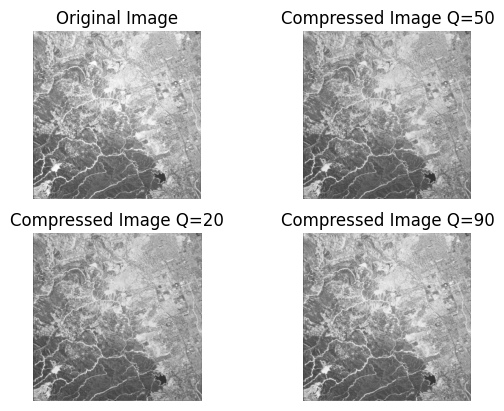

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


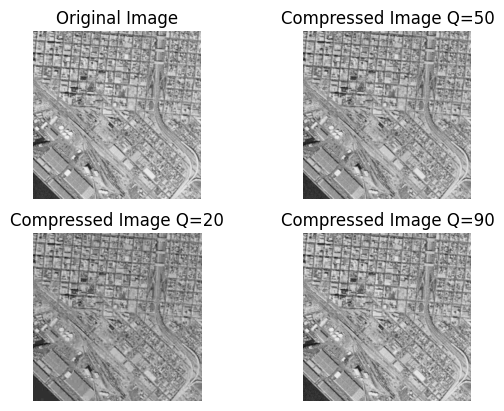

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


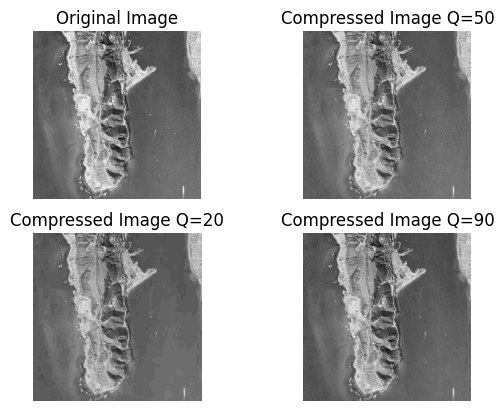

Compressed data written to compressed1.dat
Compressed data written to compressed2.dat
Compressed data written to compressed3.dat


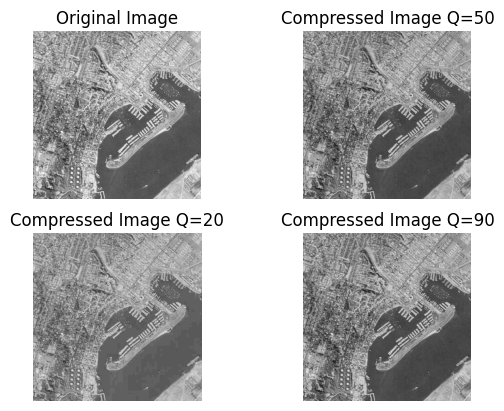

In [167]:
paths = [f"/content/{i}.tiff" for i in range(1,9)]
for path in paths:
  test_image = cv.imread(path, cv.IMREAD_GRAYSCALE)
  compressed_image_50 = engine(path, 50, 'compressed1.dat')
  compressed_image_20 = engine(path, 20, 'compressed2.dat')
  compressed_image_90 = engine(path, 90, 'compressed3.dat')


  plt.subplot(2, 2, 1)
  plt.imshow(test_image, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(2, 2, 2)
  plt.imshow(compressed_image_50, cmap='gray')
  plt.title('Compressed Image Q=50')
  plt.axis('off')

  plt.subplot(2, 2, 3)
  plt.imshow(compressed_image_20, cmap='gray')
  plt.title('Compressed Image Q=20')
  plt.axis('off')

  plt.subplot(2, 2, 4)
  plt.imshow(compressed_image_90, cmap='gray')
  plt.title('Compressed Image Q=90')
  plt.axis('off')

  plt.show()

Compressed data written to compressed_Q30
Compressed data written to compressed_Q40
Compressed data written to compressed_Q50
Compressed data written to compressed_Q60
Compressed data written to compressed_Q70
Compressed data written to compressed_Q90
Compressed data written to compressed_Q30
Compressed data written to compressed_Q40
Compressed data written to compressed_Q50
Compressed data written to compressed_Q60
Compressed data written to compressed_Q70
Compressed data written to compressed_Q90
Compressed data written to compressed_Q30
Compressed data written to compressed_Q40
Compressed data written to compressed_Q50
Compressed data written to compressed_Q60
Compressed data written to compressed_Q70
Compressed data written to compressed_Q90
Compressed data written to compressed_Q30
Compressed data written to compressed_Q40
Compressed data written to compressed_Q50
Compressed data written to compressed_Q60
Compressed data written to compressed_Q70
Compressed data written to compres

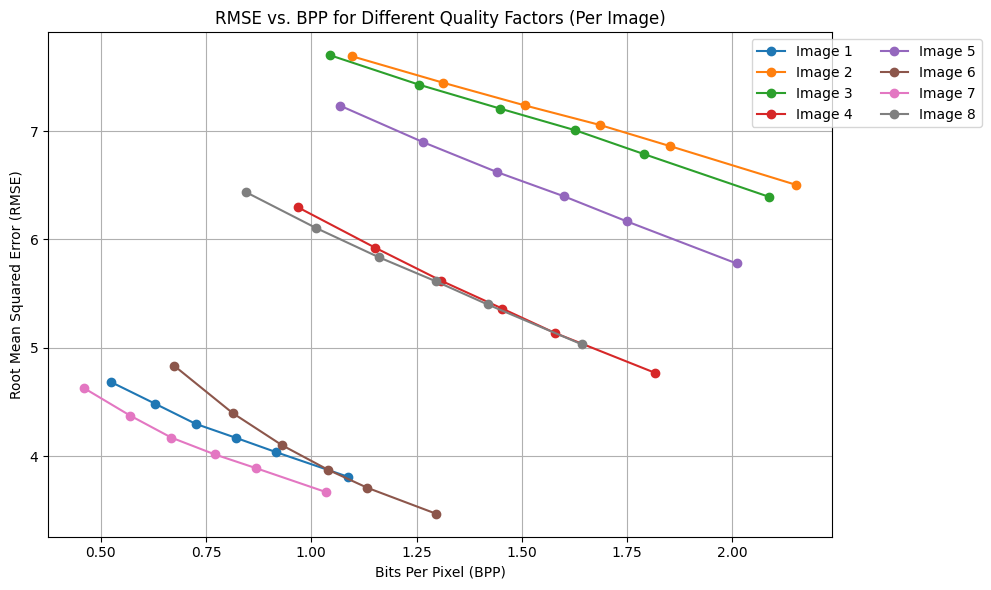

In [172]:
def simulate_quality_factors(image_path, output_file_template):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    rows, cols = img.shape[:2]
    quality_factors = [30, 40, 50, 60, 70, 90]

    rmse_vals = []
    bpp_vals = []

    for Q in quality_factors:

        file_path = output_file_template.format(Q)
        reconstructed_image = engine(image_path, Q, file_path)
        rmse_ = rmse(reconstructed_image, img)
        bpp = calculate_bpp(file_path, rows, cols)
        rmse_vals.append(rmse_)
        bpp_vals.append(bpp)
    return rmse_vals, bpp_vals

# Prepare paths and store results
all_rmse_values = []
all_bpp_values = []

for path in paths:
    rmse_vals, bpp_vals = simulate_quality_factors(path, 'compressed_Q{}')
    all_rmse_values.append(rmse_vals)
    all_bpp_values.append(bpp_vals)

# Plot RMSE vs. BPP for all images
plt.figure(figsize=(10, 6))
for i in range(len(paths)):
    plt.plot(all_bpp_values[i], all_rmse_values[i], marker='o', label=f'Image {i+1}')

plt.title('RMSE vs. BPP for Different Quality Factors (Per Image)')
plt.xlabel('Bits Per Pixel (BPP)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

## References
- OpenCV Docs https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga85aad4d668c01fbd64825f589e3696d4
- Numpy Docs https://numpy.org/doc/stable/reference/generated/numpy.array.html
-  OpenCV Docs https://docs.opencv.org/4.x/d3/df2/tutorial_py_basic_ops.html
- G4G https://www.geeksforgeeks.org/numpy-divide-python/
- G4G https://www.geeksforgeeks.org/numpy-round_-python/
- OpenCV Docs https://answers.opencv.org/question/9578/how-to-get-dct-of-an-image-in-python-using-opencv/
- G4G https://www.geeksforgeeks.org/bin-in-python/
- G4G https://www.geeksforgeeks.org/huffman-coding-greedy-algo-3/
- Stackoverflow https://stackoverflow.com/questions/41300583/how-to-create-a-frequency-matrix
- G4G https://www.geeksforgeeks.org/python-dictionary/
- G4G https://www.geeksforgeeks.org/change-the-dimension-of-a-numpy-array/?ref=lbp
- Stackoverflow https://stackoverflow.com/questions/11904083/how-to-get-image-size-bytes-using-pil
- SIPI Image Databse https://sipi.usc.edu/database/database.php?volume=aerials
- Stackoverflow https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy
- Python Docs https://docs.python.org/3/library/struct.html
- W3S https://www.w3schools.com/python/module_os.asp